In [7]:
## explore the plot interactively
#matplotlib notebook
%matplotlib widget
## import modules
import nidaqmx
import numpy as np
import time
import pyvisa
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#from devicesLib import PAX1000
from ctypes import *
import matplotlib.pyplot as plt

In [8]:
system = nidaqmx.system.System.local()
system.driver_version

for device in system.devices:
    print(device)

DaqNotFoundError: NI-DAQmx Python is not supported on this platform: darwin. Please direct any questions or feedback to National Instruments.

In [4]:
# PolaMeter = PAX1000()
# PolaMeter.getCurrSetting()
# print('PolaMeter initialized...')
instAddress = 'TCPIP0::100.65.21.49::inst0::INSTR'
psHandler = pyvisa.ResourceManager().open_resource(instAddress)
psHandler.write(':POL:WAV 1.550E-6') ## 1550nm default
psHandler.write(':POL:POW:UNIT 0') ## dBm default 0; 1 for watt
print('PolaSynth initialized...')

PolaSynth initialized...


In [5]:
# dataTemp = PolaMeter.getSingleMeas() ## get meas
# print(dataTemp)

dataTemp = psHandler.query(':POL:SOP?').strip().split(',')
print(dataTemp)

# power_original= 9.44e-5

P= 10**(float(dataTemp[0])/10) #1mW 
P_DB=10*np.log10(P)
print(P_DB)
print(float(dataTemp[0])-30)

#original from laser: 1.0002mW
#with the PM fiber strecther: 1.00002mW

['+8.48488780E-05', '+6.41724182E-05', '+5.15415522E-05', '-1.85873450E-05']


In [7]:
task = nidaqmx.Task()
task.ao_channels.add_ao_voltage_chan("Dev1/ao0")
task_status=1
# for i in range(1,2,1):
#     task.write([i])
# task.close()

In [8]:
#log stokes parameter from keysight

dataVolt, Stokes1, Stokes2, Stokes3, Power = [], [], [], [], []
# task = nidaqmx.Task()
# task.ao_channels.add_ao_voltage_chan("Dev1/ao1")
if task_status==0:
    task =  nidaqmx.Task()
    task.ao_channels.add_ao_voltage_chan("Dev1/ao1")
#voltageamp conenct to fiber stretcher
for voltageamp in range (1,150,1): ###(start end interval)
    gain=30
    voltagedaq= voltageamp/gain
    task.write([voltagedaq], auto_start = True)
    time.sleep(1)
#   dataTemp = PolaMeter.getSingleMeas()
    dataTemp = psHandler.query(':POL:SOP?').strip().split(',')
    dataTemp = [float(i) for i in dataTemp]
    
    dataVolt.append(voltagedaq);
    Power.append(float(dataTemp[0])-30) #1mW );
    
    DOP = (dataTemp[1]**2+dataTemp[2]**2+dataTemp[3]**2)**0.5/dataTemp[0];
    Stokes1.append(dataTemp[1]/dataTemp[0]/DOP); 
    Stokes2.append(dataTemp[2]/dataTemp[0]/DOP); 
    Stokes3.append(dataTemp[3]/dataTemp[0]/DOP); 
else:
    task.close()
    task_status=0
    print(" finished!")

 finished!


In [9]:
#create file, logger Voltage-stokes data
filename=r'C:\Users\LABUSERS\Desktop\phase compensation\PM fiber stretcher_peizo\characterization_V_P_Stokes.cvs'
with open(filename, 'w') as creating_new_csv_file: 
   pass 
print("Empty File Created Successfully")
############create title
import csv
with open(filename, 'w', newline='') as csvfile:
   # Create a CSV writer object 
   writer = csv.writer(csvfile) 
    # Iterate over the lists and write each element to a separate column 
   writer.writerow(["dataVolt","Power", "Stokes1", "Stokes2", "Stokes3"]) 
   for i in range(len(dataVolt)-1): 
        writer.writerow([dataVolt[i+1]*30, Power[i+1],Stokes1[i+1], Stokes2[i+1], Stokes3[i+1]]) 

Empty File Created Successfully


NameError: name 'dataVolt' is not defined

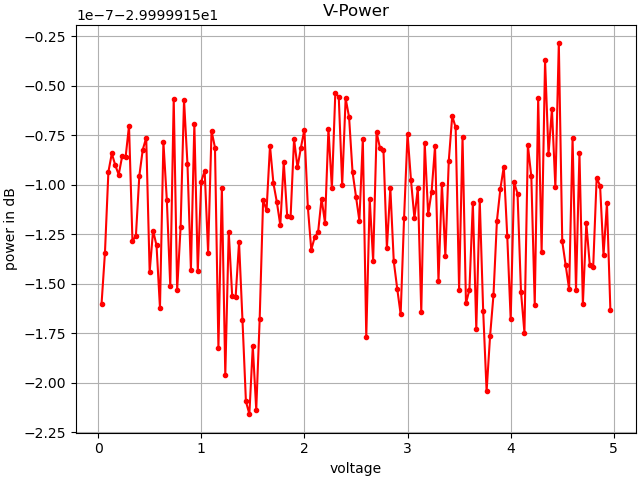

In [20]:
## plotting V-Power
import matplotlib.pyplot as plt
figHandler, axHandler = plt.subplots(1, 1, layout='constrained')
dataVoltamp = [x * 30 for x in dataVolt]
plt.plot(dataVolt, Power, '.-r')
plt.grid(True);  
plt.title("V-Power")
plt.xlabel('voltage')
plt.ylabel("power in dB")
plt.show()

In [14]:
#read stokes paramter from file, used for later analysis

import csv
from collections import defaultdict
import matplotlib.pyplot as plt
from pandas import *

#name=r"C:\Users\LABUSERS\Documents\Thorlabs\PAX1000\Sample_SM2m_0320_2am_5pm.csv"
name=r"C:\Users\LABUSERS\Desktop\phase compensation\SM fiber strecther_thermal\PAX\0803_0141PM_40m_SMF_themal_thermal _conrol.csv"
name="/Volumes/Shared/AdvancedInterconnects/Qingjun/phase compensation/SM fiber strecther_thermal/PAX/0803_0141PM_40m_SMF_themal_thermal _conrol.csv"
print(name)
from pandas import *
data = read_csv(name,encoding= 'unicode_escape')

Stokes1= data[' Normalized s 1 '].tolist()
Stokes2= data[' Normalized s 2 '].tolist()
Stokes3= data[' Normalized s 3 '].tolist()
S0= data[' S 0 [mW]'].tolist()


/Volumes/Shared/AdvancedInterconnects/Qingjun/phase compensation/SM fiber strecther_thermal/PAX/0803_0141PM_40m_SMF_themal_thermal _conrol.csv


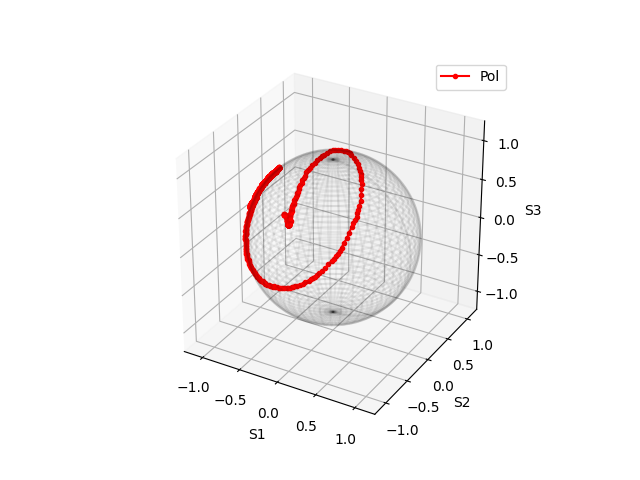

In [15]:
## sphere wireframe

diameter_sphere = 1
theta, phi = np.meshgrid(np.linspace(0, 2*np.pi, 100), np.linspace(0, np.pi, 100))
x_sphere, y_sphere, z_sphere = np.sin(phi)*np.cos(theta), np.sin(phi)*np.sin(theta), np.cos(phi)

figHandler = plt.figure()
axHandler = figHandler.add_subplot(111, projection='3d')
axHandler.plot(Stokes1, Stokes2, Stokes3, '.-r', label='Pol')
axHandler.plot_wireframe(diameter_sphere*x_sphere, diameter_sphere*y_sphere, diameter_sphere*z_sphere, color='k', alpha=0.05)

axHandler.set_xlim([-1.2, 1.2]); axHandler.set_ylim([-1.2, 1.2]); axHandler.set_zlim([-1.2, 1.2])
axHandler.set_xlabel('S1'); axHandler.set_ylabel('S2'); axHandler.set_zlabel('S3')
axHandler.set_box_aspect([1, 1, 1])
plt.legend(); plt.show()

# test

In [ ]:
with nidaqmx.Task() as task:
        task.ao_channels.add_ao_voltage_chan("Dev1/ao1")
        task.write([0.5], auto_start = True)
        
        #in the unit of V
        